In [1]:
import torch
from collections import defaultdict
import math
import matplotlib.pyplot as plt

def cim_column_bitpair_counts(ip, w, input_bits=8, weight_bits=5):
    """
    Returns:
      - inputbit_summary[ib]  → counts for each input bit
      - weightbit_summary[wb] → counts for each weight bit
      - total_summary         → global totals
    """

    _, _, H, W = ip.shape
    _, _, KH, KW = w.shape
    assert W == KW, "Input width must equal kernel width."

    ip_col = ip[0, 0, :, 0]

    inputbit_summary  = {}  # ✅ renamed: per input bit summary
    weightbit_summary = defaultdict(lambda: defaultdict(int))
    total_summary     = defaultdict(int)

    for ib in range(input_bits):
        c = defaultdict(int)

        ip_bitvec = ((ip_col >> ib) & 1).to(torch.uint8)

        for row in range(KH):
            for col in range(KW):
                w_val = w[0,0,row,col].item()

                for wb in range(weight_bits):
                    w_bit = (w_val >> wb) & 1
                    pair  = (int(ip_bitvec[row].item()), w_bit)

                    c[str(pair)] += 1
                    weightbit_summary[wb][str(pair)] += 1
                    total_summary[str(pair)] += 1

        inputbit_summary[ib] = dict(c)

    return inputbit_summary, weightbit_summary, total_summary


ip = torch.tensor([[[[1 ,0,0],
                     [0 ,0,0],
                     [0 ,0,0]]]], dtype=torch.uint8)

w1 = torch.tensor([[[[1,2,3],
                     [0,0,0],
                     [0,0,0]]]], dtype=torch.uint8)

inputbit_summary, weightbit_summary, totals = cim_column_bitpair_counts(ip, w1)

print("\n=== Per Input-Bit Summary ===")
for ib in inputbit_summary:
    print(f"Input bit {ib}: {inputbit_summary[ib]}")




=== Per Input-Bit Summary ===
Input bit 0: {'(1, 1)': 4, '(1, 0)': 11, '(0, 0)': 30}
Input bit 1: {'(0, 1)': 4, '(0, 0)': 41}
Input bit 2: {'(0, 1)': 4, '(0, 0)': 41}
Input bit 3: {'(0, 1)': 4, '(0, 0)': 41}
Input bit 4: {'(0, 1)': 4, '(0, 0)': 41}
Input bit 5: {'(0, 1)': 4, '(0, 0)': 41}
Input bit 6: {'(0, 1)': 4, '(0, 0)': 41}
Input bit 7: {'(0, 1)': 4, '(0, 0)': 41}


In [2]:

def _pad_input_2d(x, padding):
    if padding == 0:
        return x
    # x: (N, C, H, W)
    N,C,H,W = x.shape
    out = torch.zeros((N,C,H + 2*padding, W + 2*padding), dtype=x.dtype)
    out[:, :, padding:padding+H, padding:padding+W] = x
    return out

def cim_conv_cmem_full(ip, w, cmem_rows, cmem_cols,
                       stride=1, padding=0,
                       input_bits=8, weight_bits=5):
    """
    CMEM-accurate, multi-channel, multi-output, full convolution.
    - ip: (N, IC, H, W)   uint8
    - w:  (OC, IC, KH, KW) uint8
    - CMEM is a 2D MAC fabric: rows x cols.
      Each OC slice occupies a KHxKW block at a tile: rows [0..KH-1], cols [tile*KW .. tile*KW+KW-1].
      Multiple OCs are packed horizontally; remaining cells are zero.
    - Time schedule (per time step):
        * Choose kernel-column offset k in [0..KW-1]
        * Choose input channel c in [0..IC-1]   (channel-serialized)
        * Choose input bit b in [0..input_bits-1] (bit-serial)
        * Build input CMEM column-vector of length cmem_rows from ip[:, c, :, xcol] (top-padded/truncated)
        * Multiply row-wise against whole CMEM (all cols), weight-bit expanded
    - If CMEM cannot fit all OCs in its width, process OCs in batches.
    - Returns per-time-step bit-pair counts and a rich timeline.
    """
    assert ip.dtype == torch.uint8 and w.dtype == torch.uint8, "Use uint8 tensors."

    N, IC, H, W = ip.shape
    OC, IC2, KH, KW = w.shape
    assert IC == IC2, "Input channels must equal weight IC."
    assert KH <= cmem_rows and KW <= cmem_cols, "Kernel must fit in CMEM."

    # Pad input (symmetric zero-padding)
    ip_p = _pad_input_2d(ip, padding)
    _, _, Hpad, Wpad = ip_p.shape

    # Output spatial dims (valid conv formula with padding/stride)
    OH = (Hpad - KH) // stride + 1
    OW = (Wpad - KW) // stride + 1

    # How many OC kernels fit across CMEM columns at once?
    oc_per_batch = max(1, cmem_cols // KW)
    num_batches = math.ceil(OC / oc_per_batch)

    per_timestep_counts = []
    timeline = []  # (oy, ox, k, c, b, batch_idx, oc_start, oc_end)

    # Loop over output columns (stream column-vectors)
    for oy in range(OH):
        for ox in range(OW):
            # The three input columns used by this output column are:
            # xcol = ox*stride + k  for k in [0..KW-1]
            for k in range(KW):
                xcol = ox*stride + k
                yrow_start = oy*stride

                # Channel-serialized
                for c in range(IC):
                    # Build input CMEM vector (length cmem_rows)
                    # Take the vertical slice of length KH starting at yrow_start, but
                    # to satisfy CMEM-row model we stream the *whole* input column and pad/truncate to cmem_rows.
                    # (If you want only KH active rows, set use_h = KH and take ip_p[:, c, yrow_start:yrow_start+KH, xcol])
                    col_vec = ip_p[0, c, :, xcol]  # full padded column (Hpad)
                    cmem_in = torch.zeros((cmem_rows,), dtype=torch.uint8)
                    use_h = min(cmem_rows, col_vec.numel())
                    cmem_in[:use_h] = col_vec[:use_h]

                    # Process OCs in batches across CMEM width
                    for batch_idx in range(num_batches):
                        oc_start = batch_idx * oc_per_batch
                        oc_end   = min(OC, (batch_idx+1) * oc_per_batch)
                        batch_ocs = oc_end - oc_start

                        # Build CMEM weights for this batch (rows x cols)
                        cmem_w = torch.zeros((cmem_rows, cmem_cols), dtype=torch.uint8)
                        for b_tile, oc_id in enumerate(range(oc_start, oc_end)):
                            # Place KHxKW at columns [b_tile*KW : b_tile*KW + KW]
                            col0 = b_tile * KW
                            cmem_w[0:KH, col0:col0+KW] = w[oc_id, c, :, :]

                        # Bit-serial over input bits
                        for b_in in range(input_bits):
                            ip_bits = ((cmem_in >> b_in) & 1).to(torch.uint8)
                            counts = defaultdict(int)

                            # Row-wise multiply: for each row, multiply ip_bit with *all columns* in that row
                            # This gives cmem_rows * cmem_cols multiplications per bit (then × weight_bits)
                            for r in range(cmem_rows):
                                ipb = int(ip_bits[r].item())
                                row_vals = cmem_w[r, :]  # (cmem_cols,)
                                for cc in range(cmem_cols):
                                    wv = int(row_vals[cc].item())
                                    # expand weight bits
                                    for wb in range(weight_bits):
                                        wbv = (wv >> wb) & 1
                                        counts[str((ipb, wbv))] += 1
                            out = {
                                "(0, 0)": counts.get("(0, 0)", 0),
                                "(0, 1)": counts.get("(0, 1)", 0),
                                "(1, 0)": counts.get("(1, 0)", 0),
                                "(1, 1)": counts.get("(1, 1)", 0),
                            }
                            per_timestep_counts.append(out)
                            timeline.append((oy, ox, k, c, b_in, batch_idx, oc_start, oc_end))

    meta = {
        "OH": OH, "OW": OW,
        "oc_per_batch": oc_per_batch,
        "num_batches": num_batches,
        "cmem_rows": cmem_rows, "cmem_cols": cmem_cols,
        "input_bits": input_bits, "weight_bits": weight_bits
    }
    return per_timestep_counts, timeline, meta
def plot_bitpair_timeline(per_timestep_counts, start=0, length=16, title="Bit-Pair Counts per Time Step"):
    end = min(len(per_timestep_counts), start + length)
    ts = list(range(start, end))
    keys = ["(0, 0)", "(1, 0)", "(0, 1)", "(1, 1)"]

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, k in enumerate(keys):
        vals = [per_timestep_counts[t][k] for t in ts]
        ax = axes[i]
        ax.plot(ts, vals)
        ax.set_title(k)
        ax.set_xlabel("time step")
        ax.set_ylabel("count")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

ip = torch.tensor([[[[1 ,0,0],
                     [0 ,0,0],
                     [0 ,0,0]]]], dtype=torch.uint8)

w  = torch.tensor([[[[1,2,3],
                     [0,0,0],
                     [0,0,0]]]], dtype=torch.uint8)  # (OC=1, IC=1, KH=3, KW=3)

ip_large = torch.randint(
    low=0, high=256,
    size=(1, 3, 224, 224),
    dtype=torch.uint8
)

w_large = torch.randint(
    low=0, high=256,
    size=(10, 3, 3, 3),
    dtype=torch.uint8
)

counts, timeline, meta = cim_conv_cmem_full(
    ip, w,
    cmem_rows=256, cmem_cols=64,
    stride=1, padding=0,
    input_bits=8, weight_bits=5
)

for t in range(8):
    print(f"t={t}, info={timeline[t]}, counts={counts[t]}")

# plot_bitpair_timeline(counts, start=0, length=16, title="CMEM 5×5 (toy case)")


t=0, info=(0, 0, 0, 0, 0, 0, 0, 1), counts={'(0, 0)': 81600, '(0, 1)': 0, '(1, 0)': 316, '(1, 1)': 4}
t=1, info=(0, 0, 0, 0, 1, 0, 0, 1), counts={'(0, 0)': 81916, '(0, 1)': 4, '(1, 0)': 0, '(1, 1)': 0}
t=2, info=(0, 0, 0, 0, 2, 0, 0, 1), counts={'(0, 0)': 81916, '(0, 1)': 4, '(1, 0)': 0, '(1, 1)': 0}
t=3, info=(0, 0, 0, 0, 3, 0, 0, 1), counts={'(0, 0)': 81916, '(0, 1)': 4, '(1, 0)': 0, '(1, 1)': 0}
t=4, info=(0, 0, 0, 0, 4, 0, 0, 1), counts={'(0, 0)': 81916, '(0, 1)': 4, '(1, 0)': 0, '(1, 1)': 0}
t=5, info=(0, 0, 0, 0, 5, 0, 0, 1), counts={'(0, 0)': 81916, '(0, 1)': 4, '(1, 0)': 0, '(1, 1)': 0}
t=6, info=(0, 0, 0, 0, 6, 0, 0, 1), counts={'(0, 0)': 81916, '(0, 1)': 4, '(1, 0)': 0, '(1, 1)': 0}
t=7, info=(0, 0, 0, 0, 7, 0, 0, 1), counts={'(0, 0)': 81916, '(0, 1)': 4, '(1, 0)': 0, '(1, 1)': 0}


In [3]:
import torch
from collections import defaultdict

def overlap_bitpair_counts(ip, w, input_bits=8, weight_bits=8):
    """
    Compute:
      1) How many times each input pixel participates (reuse)
      2) How many actual bitwise multiplications happen per pixel for (1,1),(1,0),(0,1),(0,0)
    ip: Input tensor [1,1,H,W], dtype=uint8
    w: Kernel tensor [1,1,KH,KW], dtype=uint8
    Returns:
      reuse_map: HxW tensor of reuse counts
      bitpair_map: HxW dict of bitwise pair counts
      reuse_histogram: dict -> how many pixels are used 1x,2x,etc
    """
    _, _, H, W = ip.shape
    _, _, KH, KW = w.shape
    OH, OW = H - KH + 1, W - KW + 1

    reuse_map = torch.zeros((H, W), dtype=torch.int32)
    # Initialize map of dicts per pixel
    bitpair_map = [[defaultdict(int) for _ in range(W)] for _ in range(H)]

    for oy in range(OH):
        for ox in range(OW):
            region = ip[0, 0, oy:oy+KH, ox:ox+KW]
            for i in range(KH):
                for j in range(KW):
                    reuse_map[oy+i, ox+j] += 1
                    ip_val = region[i,j].item()
                    w_val = w[0,0,i,j].item()
                    for ib in range(input_bits):
                        ip_bit = (ip_val >> ib) & 1
                        for wb in range(weight_bits):
                            w_bit = (w_val >> wb) & 1
                            pair = (ip_bit, w_bit)
                            if pair == (1,1):
                                bitpair_map[oy+i][ox+j]["(1,1)"] += 1
                            elif pair == (1,0):
                                bitpair_map[oy+i][ox+j]["(1,0)"] += 1
                            elif pair == (0,1):
                                bitpair_map[oy+i][ox+j]["(0,1)"] += 1
                            else:
                                bitpair_map[oy+i][ox+j]["(0,0)"] += 1

    # Histogram of reuse frequency
    unique, counts = torch.unique(reuse_map, return_counts=True)
    reuse_histogram = {int(k): int(v) for k,v in zip(unique, counts)}

    return reuse_map, bitpair_map, reuse_histogram

ip = torch.tensor([[[[1 ,0,0,0,0,0,0],
                     [0 ,0,0,0,0,0,0],
                     [0 ,0,0,0,0,0,0],
                     [0 ,0,0,0,0,0,0],
                     [0 ,0,0,0,0,0,0],
                     [0 ,0,0,0,0,0,0],
                     [0 ,0,0,0,0,0,0]]]], dtype=torch.uint8)

w = torch.tensor([[[[1,2,3],
                    [0,0,0],
                    [0,0,0]]]], dtype=torch.uint8)

reuse_map, bitpair_map, reuse_hist = overlap_bitpair_counts(ip, w, input_bits=2, weight_bits=4)

print("Reuse map:\n", reuse_map)
print("\nReuse histogram:\n", reuse_hist)
print("\nBitwise pair map for top-left pixel:\n", bitpair_map[0][0])


Reuse map:
 tensor([[1, 2, 3, 3, 3, 2, 1],
        [2, 4, 6, 6, 6, 4, 2],
        [3, 6, 9, 9, 9, 6, 3],
        [3, 6, 9, 9, 9, 6, 3],
        [3, 6, 9, 9, 9, 6, 3],
        [2, 4, 6, 6, 6, 4, 2],
        [1, 2, 3, 3, 3, 2, 1]], dtype=torch.int32)

Reuse histogram:
 {1: 4, 2: 8, 3: 12, 4: 4, 6: 12, 9: 9}

Bitwise pair map for top-left pixel:
 defaultdict(<class 'int'>, {'(1,1)': 1, '(1,0)': 3, '(0,1)': 1, '(0,0)': 3})


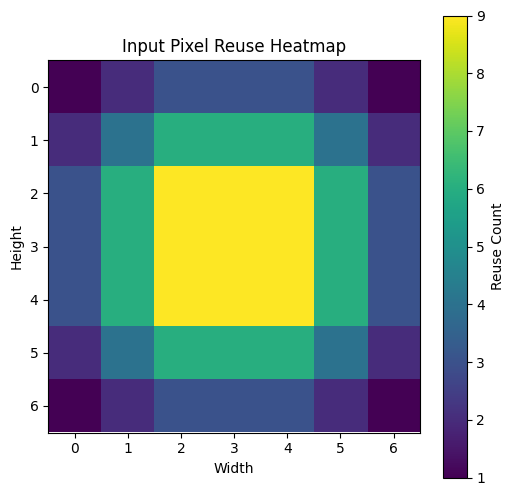

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(reuse_map.numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Reuse Count')
plt.title('Input Pixel Reuse Heatmap')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()
